# Searching for a Needle in a "Signal Haystack" with recording

### Note to me: source ~/venv38/bin/Activate, then run "jupyter lab"
### use https://onlinetonegenerator.com/


In [1]:
from os.path import exists
file_exists = exists('basic_material.py')
if (not file_exists):
    !wget -O basic_material.py https://raw.githubusercontent.com/JonHowMIT/Signals_and_Systems/main/basic_material.py
%run basic_material

import numpy as np
try:
    import pyaudio
except:
    !pip3 install pyaudio
    import pyaudio

import wave, time, struct, os, csv

from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, ifft
from scipy.signal import blackman
from scipy.io.wavfile import write

try:
    import librosa, librosa.display
except:
    !pip3 install librosa
    import librosa, librosa.display

def nicegrid(ax=plt):
    ax.grid(True, which='major', color='#666666', linestyle=':')
    ax.grid(True, which='minor', color='#999999', linestyle=':', alpha=0.2)
    ax.minorticks_on()

Running Python: 3.8.19
Running Sympy: 1.12.1


In [2]:
# store data
def store_data(signal,stack):
    # sum will treat Boolean True as a 1, False as a 0
    n = sum(os.path.isfile("data/"+name) for name in os.listdir('data/'))
    file_name = "data/Store_%s" % n 
    print("\nStoring recorded data in",file_name)

    np.savetxt(file_name+"_signal.csv", signal, delimiter=",")
    np.savetxt(file_name+"_stack.csv", stack, delimiter=",")

    signal_read = np.loadtxt(file_name+"_signal.csv",delimiter=',',skiprows=0)  
    stack_read = np.loadtxt(file_name+"_stack.csv",delimiter=',',skiprows=0)  

    print(f"Signal reload errors of {np.max(np.abs(signal_read - signal)):.6e}")
    print(f"Stack reload errors of {np.max(np.abs(stack_read - stack)):.6e}\n")
    
    return file_name

## Pattern Matching

* Thus we have to do pattern matching - we basically create a replica signal as 
above, and then choose a range of $0\leq\phi\leq 2\pi$ to see if any match better than others

* Matching deptermined by computing the *correlation*
$$ C[j] =\sum_i y_{meas}[i] y_{replica}[i,j]$$
where $i$ is the index over mesurements taken and $j$ determines what value of $\phi$ is being used

* Must pay attention to the end points of the replica signal (use np.roll).

* We don't know the right amplitude to use either, but that is a scaling error in all $C[j]$ values - so can just look for the largest value across all computed.

In [3]:
# Implement the correlation process between 2 signals - sweep overal all possible ofsrets in 1 loop
def my_correlate(A,B,N = 10):
    C = np.zeros([N,1]) # confirm which N is being used
    for ii in np.arange(0,N):
        C[ii] = np.correlate(A, np.roll(B,ii))
    return C

In [4]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
sr = 44100
dt = 1/sr
chunk_size = 512
WAVE_OUTPUT_FILENAME = "data/TF_recordedFile.wav"
audio = pyaudio.PyAudio()

In [5]:
p = pyaudio.PyAudio()
device_keep_list = []
print("----------------------record device list---------------------")
info = p.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))
            if (p.get_device_info_by_host_api_device_index(0, i).get('name')[0:7] == 'MacBook'):
                device_keep_list = np.append(device_keep_list,i)

print("-------------------------------------------------------------")
print(int(device_keep_list[0]))

----------------------record device list---------------------
Input Device id  1  -  LG UltraFine Display Audio
Input Device id  3  -  HD Pro Webcam C920
Input Device id  4  -  JHow72 Microphone
Input Device id  5  -  MacBook Pro Microphone
Input Device id  7  -  Microsoft Teams Audio
Input Device id  8  -  ZoomAudioDevice
-------------------------------------------------------------
5


In [6]:
tf = 10 # amount of data to collect
hop_length = 256 
t_start = 1 # start time for processing

for kk in device_keep_list:
    stream = p.open(format=pyaudio.paFloat32,channels=1,rate=sr,input=True,input_device_index=kk,frames_per_buffer=chunk_size)
alldata =[]
frames = []

start = time.time()
t_now = start
while (time.time() < start + tf):
    data = stream.read(chunk_size,exception_on_overflow = False)
    DATA = np.frombuffer(data, dtype=np.float32)
    alldata.append(DATA)
    melspec = librosa.feature.melspectrogram(y = DATA, sr=sr, n_mels=128, fmax=4096/2)
    norm_melspec = librosa.core.power_to_db(melspec, ref = np.max)
    frames.append(norm_melspec)
    if time.time() - t_now > 0.5:
        print(f"{time.time() - start:.1f} ",  end = '')
        t_now = time.time()

signal = np.hstack(alldata)
stack = np.hstack(frames)

stored_file_names = store_data(signal,stack)

y = signal
N = len(y) # number of pts collected
t = np.arange(N)/sr # time array
tf = np.max(t) # amount of data actually collected
amp = np.max(np.abs(y)) # ampltiude of signal

N_start = np.argwhere(t >= t_start)[0][0] # where to start processing
sl = slice(N_start,-1)

1.2 1.7 2.2 2.7 3.2 3.7 4.2 4.7 5.2 5.7 6.3 6.8 7.3 7.8 8.3 8.8 9.3 9.8 
Storing recorded data in data/Store_551
Signal reload errors of 0.000000e+00
Stack reload errors of 0.000000e+00



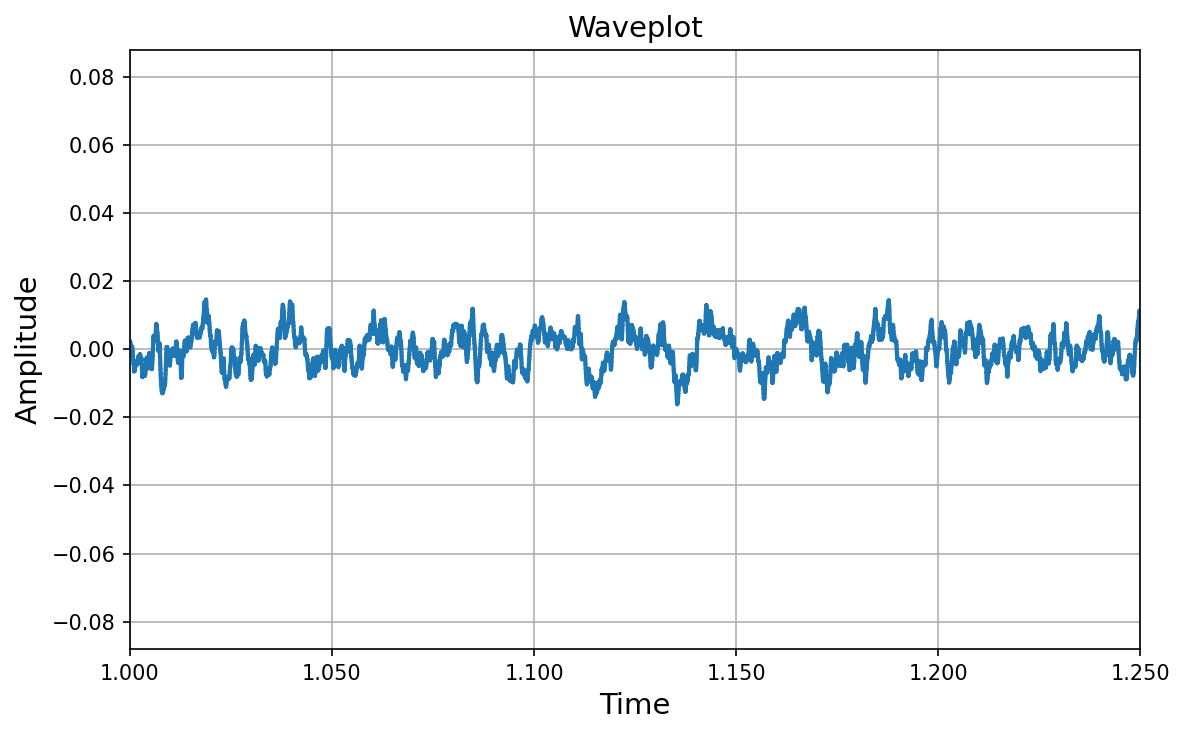

Signal saved as 'data/Store_551.wav'


In [7]:
plt.figure(figsize=(8, 5))
h = librosa.display.waveshow(signal, sr=sr)
plt.title('Waveplot', fontdict=dict(size=14))
plt.xlabel('Time', fontdict=dict(size=14))
plt.ylabel('Amplitude', fontdict=dict(size=14))
plt.xlim(t_start,t_start+0.25)
#plt.savefig('./figs/mic_0.png', bbox_inches='tight', dpi=300)
plt.show()

# Normalize the signal to the range of int16
Signal = np.int16(signal / np.max(np.abs(signal)) * 32767)

# Save the signal as a WAV file
write(stored_file_names+'.wav', sr, Signal)

print(f"Signal saved as '{stored_file_names+'.wav'}'")

In [8]:
if 0:
    omega_lower_bound = 1000*2*np.pi
    omega_upper_bound = 1080*2*np.pi
    omega_guess = 1045*2*np.pi
else:
    #https://onlinetonegenerator.com/multiple-tone-generator.html?f[]=440&f[]=600&f[]=800&w[]=si&w[]=si&w[]=si&v[]=15&v[]=36&v[]=18
    omega_lower_bound = 40*2*np.pi
    omega_upper_bound = 200*2*np.pi
    omega_guess = 440*2*np.pi

#Must determine how data points we are going to sweep over phi - nominally depends on frequency guess
N0 = int((1/(omega_guess/2/np.pi))/dt) # number of samples per period 

## Now back to analyzing the meaured data

In [9]:
# Set up a range of possible Omega values 
# Recall truth is omega_guess
# Create a range of Nw values of possible Omegas about the true Omega0
Nw = 2 * N0
omega_range = np.linspace(omega_lower_bound,omega_upper_bound,Nw)
N_omega = index = (np.abs(omega_range - omega_guess)).argmin() # index of right answer

CC = np.zeros([len(omega_range),N0])
for ii,om in enumerate(omega_range):
    CC[ii,:] = my_correlate(np.sin(om * t[sl]),y[sl],N0).T # this sweep over all phase ofsrets 
CC /= np.max(np.max(CC))

# Look for best correlation across all freq and phi sweeps
ind = np.unravel_index(np.argmax(CC, axis=None), CC.shape)[0]
f_pred = omega_range[ind]/(2*np.pi) # Hz

print(f'Pred Freq {f_pred:.1f} Hz\n')

Pred Freq 94.7 Hz



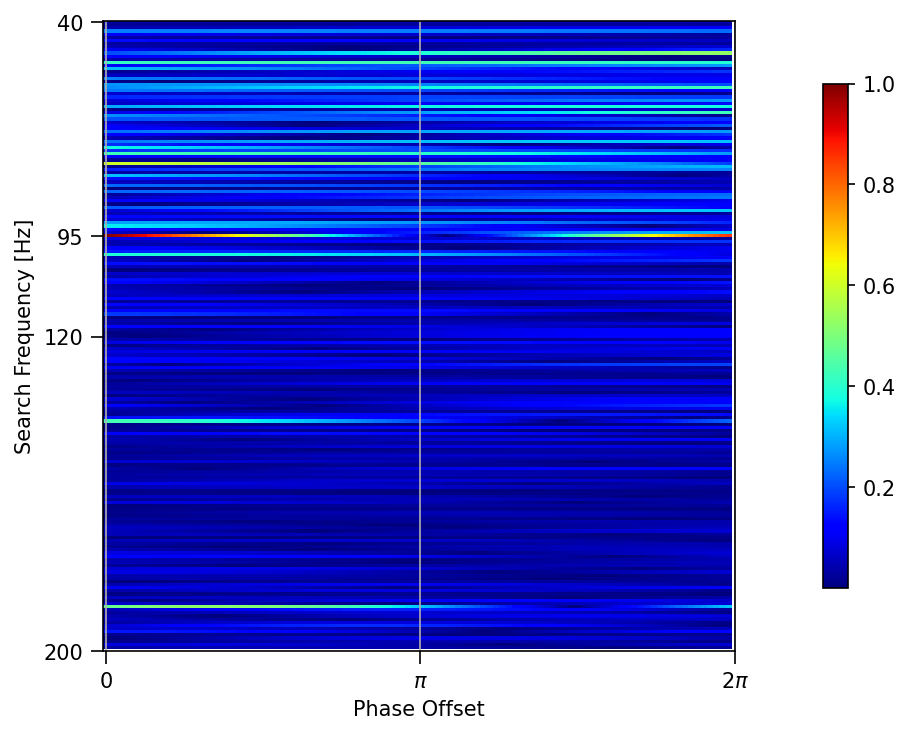

In [10]:
fig = plt.figure(figsize=(12, 5))
im = plt.imshow(np.abs(CC),cmap='jet',aspect=N0/Nw)
plt.yticks([0,ind,Nw,Nw//2],[f'{omega_range[0]/2/np.pi:.0f}',
                                 f'{omega_range[ind]/2/np.pi:.0f}',
                                 f'{omega_range[-1]/2/np.pi:.0f}',
                                 f'{omega_range[Nw//2]/2/np.pi:.0f}'])
plt.xticks([0,N0//2,N0],[0,'$\pi$','$2\pi$'])
plt.ylabel('Search Frequency [Hz]')
plt.xlabel('Phase Offset')
plt.colorbar(shrink = 0.8) 
plt.tick_params(axis='both', which='both', direction='out', length=6)
plt.grid(axis='x', linestyle='-') 
plt.grid(axis='y', visible=False)
plt.show()
#fig.savefig('./figs/Correlation3.png', dpi=300)

## Alternate Approach

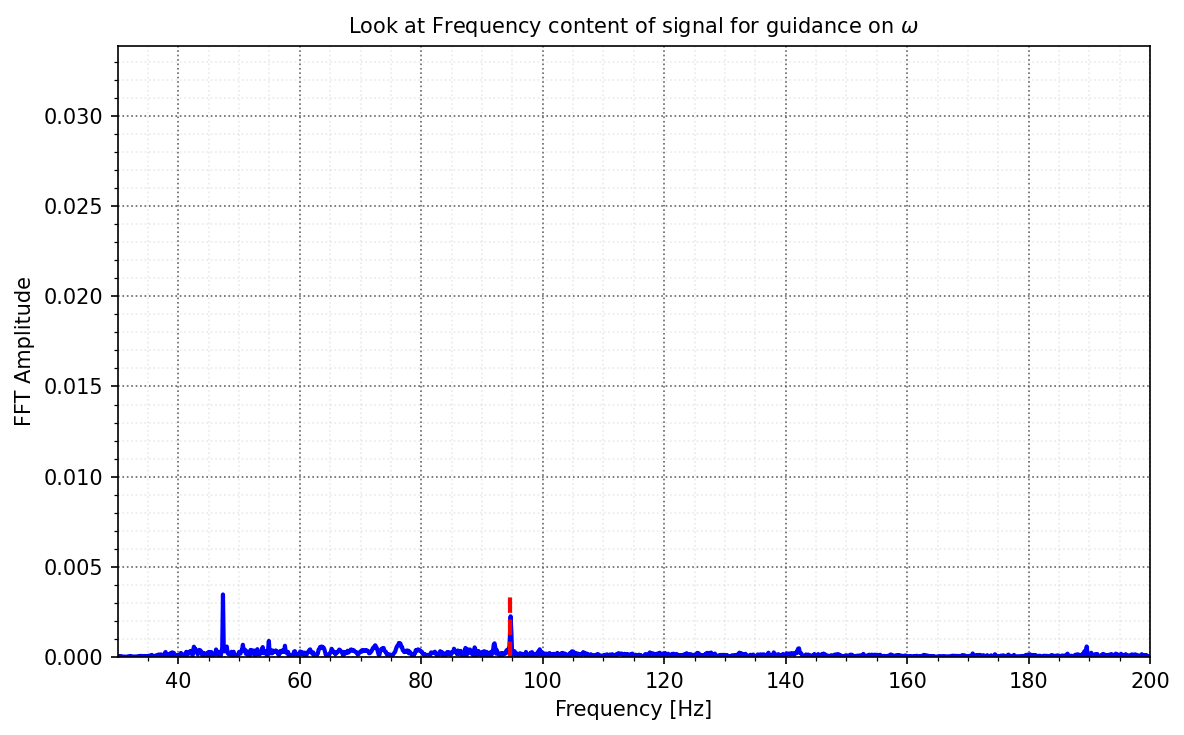

In [11]:
# Alternate way to estimate Omega given the measured data - look for the peak in the FFT plot
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
yf = fft(y[sl])
Nfft = len(yf)
ff = fftfreq(Nfft, dt)[1:Nfft//2]*2*np.pi 

ind_f = index = (np.abs(ff/2/np.pi - f_pred)).argmin() # index of the pred freq 
aamp = 1.5*np.max(2.0/Nfft * np.abs(yf[ind_f-100:ind_f+100])) # plot scaling

fig = plt.figure(figsize=(8, 5))
plt.plot(ff/2/np.pi, 2.0/Nfft * np.abs(yf[1:Nfft//2]),'b-')
plt.plot([f_pred, f_pred], [0,aamp],'r--')
plt.ylabel('FFT Amplitude')
plt.xlabel('Frequency [Hz]')
#plt.xlim([omega_lower_bound/2/np.pi, omega_upper_bound/2/np.pi])
plt.xlim([30, 200])
plt.ylim([0, aamp*10])
plt.title("Look at Frequency content of signal for guidance on $\omega$")
nicegrid()
plt.show()

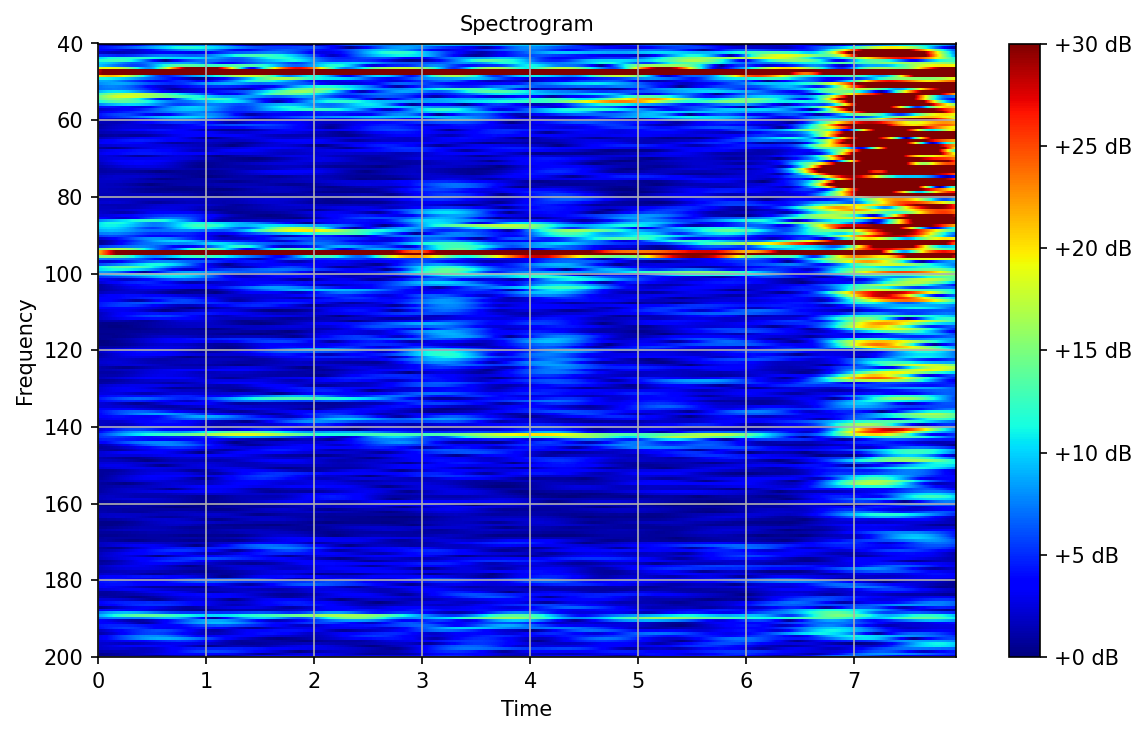

In [12]:
# Compute the spectrogram using STFT
S = np.abs(librosa.stft(y[sl],n_fft=2**16,hop_length=hop_length))

# Display the spectrogram
plt.figure(figsize=(8, 5))
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='fft', hop_length=hop_length, cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylim([omega_upper_bound/2/np.pi, omega_lower_bound/2/np.pi])
plt.ylabel('Frequency')
plt.clim(0, 30)
plt.show()

In [13]:
ipd.Audio(np.int16(y[sl] / np.max(np.abs(y[sl])) * 32767), rate=sr)

In [14]:
assert False

AssertionError: 

In [ ]:
import numpy as np 
hop_length = 256
sr = 44100

# 528
stored_file_names = "data/Store_548"

data_bells_stack = np.loadtxt(stored_file_names+'_stack.csv',delimiter=',',skiprows=0)  
data_bells_signal = np.loadtxt(stored_file_names+'_signal.csv',delimiter=',',skiprows=0)  

N = len(data_bells_signal) # number of pts collected
t = np.arange(N)/sr # time array
tf = np.max(t) # amount of data actually collected

N_start = np.argwhere(t >= 1)[0][0] # where to start processing
sl = slice(N_start,-1)

# Compute the spectrogram using STFT
Sbells = np.abs(librosa.stft(data_bells_signal[sl],n_fft=2**16,hop_length=hop_length))

write(stored_file_names+'.wav', sr, Signal)
ipd.Audio(np.int16(data_bells_signal / np.max(np.abs(data_bells_signal)) * 32767), rate=sr)

In [ ]:
# Display the spectrogram
plt.figure(figsize=(8, 5))
librosa.display.specshow(Sbells, sr=sr, x_axis='time', y_axis='fft', hop_length=hop_length, cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylim([1440, 1470])
plt.ylabel('Frequency')
plt.clim(0, 30)
plt.show()